### ITD
En este dataset tenemos fotos tomadas con 10 cámaras diferentes a diferentes telas. De cada cámara tenemos una parte de las fotos para train, en las que solamente hay fotos de telas en buen estado. Y otra parte para test, en las que hay fotos de telas en buen estado y dañadas.
El objetivo es entrenar el modelo solo con las fotos de train (tela en buen estado) y poder predecir si una foto de test es una tela en buen estado ($y_{test}=0$) o dañada ($y_{test}=1$).

In [7]:
import os
import numpy as np
from PIL import Image
from pathlib import Path

def cargar_datos_clasicos(root_path, image_size=(64, 64), grayscale=True):
    """
    Lee las imágenes y devuelve matrices X e y listas para Scikit-Learn.
    X será de forma (n_muestras, n_features).
    """
    X_train = []
    
    X_test = []
    y_test = [] # 0 = Good, 1 = Anomaly
    
    root = Path(root_path)
    
    print(f"Leyendo imágenes desde: {root_path} ...")
    
    # Recorremos recursivamente
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg']:
            continue
            
        # Detectar si es train o test y la etiqueta
        parts = img_path.parts
        try:
            split_type = parts[-3] # 'train' o 'test'
            label_str = parts[-2]  # 'good' o 'anomaly'
        except IndexError:
            continue
            
        # 1. Cargar y procesar imagen
        if grayscale:
            img = Image.open(img_path).convert('L') # Convertir a Blanco y Negro
        else:
            img = Image.open(img_path).convert('RGB')
            
        # 2. Redimensionar (CRUCIAL para ML clásico)
        img = img.resize(image_size)
        
        # 3. Convertir a numpy y aplanar (Flatten)
        # Ejemplo: una imagen 64x64 se convierte en un vector de 4096 números
        img_vector = np.asarray(img).flatten()
        
        # 4. Normalizar (dividir por 255 para tener valores entre 0 y 1)
        img_vector = img_vector / 255.0
        
        # 5. Guardar en las listas correspondientes
        if split_type == 'train':
            # En train asumimos que todo es 'good' (0)
            X_train.append(img_vector)
        elif split_type == 'test':
            is_anomaly = 1 if label_str == 'anomaly' else 0
            X_test.append(img_vector)
            y_test.append(is_anomaly)

    # Convertir listas a arrays de Numpy
    return np.array(X_train), np.array(X_test), np.array(y_test)

# --- USO ---
ruta = "./ITD" # Tu ruta
X_train, X_test, y_test = cargar_datos_clasicos(ruta, image_size=(64, 64))

print(f"Datos de Train (solo normales): {X_train.shape}")
print(f"Datos de Test: {X_test.shape}")
print(f"Etiquetas de Test: {y_test.shape}")

#Mostramos cuantas anomalías hay en test
print("Anomalías en test:", np.sum(y_test))

Leyendo imágenes desde: ./ITD ...
Datos de Train (solo normales): (4391, 4096)
Datos de Test: (1141, 4096)
Etiquetas de Test: (1141,)
Anomalías en test: 629


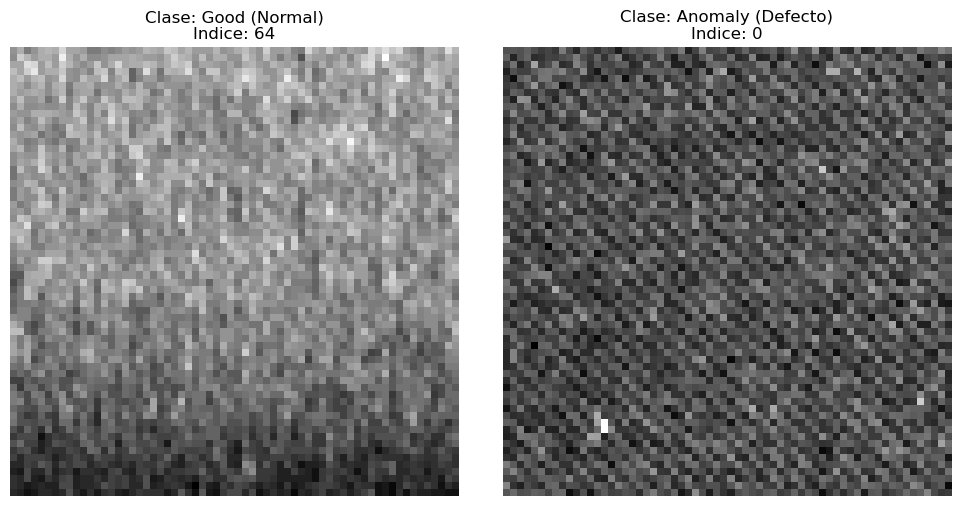

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def visualizar_ejemplos(X, y, image_size=(64, 64)):
    """
    Toma los datos aplanados, busca un ejemplo de 'Good' y uno de 'Anomaly'
    y los muestra uno al lado del otro.
    """
    # 1. Buscar índices
    # np.where devuelve los índices donde la condición es verdadera
    indices_good = np.where(y == 0)[0]
    indices_anomaly = np.where(y == 1)[0]
    
    if len(indices_good) == 0 or len(indices_anomaly) == 0:
        print("¡Error! No encontré ejemplos de ambas clases en este set.")
        return

    # Cogemos el primero de cada tipo (o podrías usar random)
    idx_good = indices_good[0]
    idx_anomaly = indices_anomaly[0] # Cogemos la primera anomalía que aparezca
    
    # 2. Recuperar las imágenes (Reshape)
    # Volvemos a convertir el vector plano (ej: 4096) a matriz (64x64)
    img_good = X[idx_good].reshape(image_size)
    img_anomaly = X[idx_anomaly].reshape(image_size)
    
    # 3. Graficar
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Imagen Normal
    axes[0].imshow(img_good, cmap='gray') # 'gray' porque cargamos en blanco y negro
    axes[0].set_title(f"Clase: Good (Normal)\nIndice: {idx_good}")
    axes[0].axis('off')
    
    # Imagen Anomalía
    axes[1].imshow(img_anomaly, cmap='gray')
    axes[1].set_title(f"Clase: Anomaly (Defecto)\nIndice: {idx_anomaly}")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- USO ---
# Asegúrate de usar el mismo tamaño (64, 64) que usaste al cargar
visualizar_ejemplos(X_test, y_test, image_size=(64, 64))

Probamos Isolation Forest simple:

In [8]:
from sklearn.ensemble import IsolationForest

# Entrenamos SOLO con los datos normales (train)
clf = IsolationForest(random_state=42, contamination=0.5) # contamination = % estimado de anomalías
clf.fit(X_train)

# Predecimos en test (devuelve 1 para normal, -1 para anomalía)
preds = clf.predict(X_test)

# Convertimos la salida de sklearn (-1, 1) al formato (0, 1)
# En sklearn: -1 es anomalía. En nuestro formato: 1 es anomalía.
preds_convertidos = [1 if x == -1 else 0 for x in preds]

--> Accuracy Global: 70.73%
------------------------------
Informe de Clasificación:
              precision    recall  f1-score   support

    Good (0)       0.76      0.51      0.61       512
 Anomaly (1)       0.69      0.86      0.77       629

    accuracy                           0.71      1141
   macro avg       0.72      0.69      0.69      1141
weighted avg       0.72      0.71      0.70      1141

------------------------------


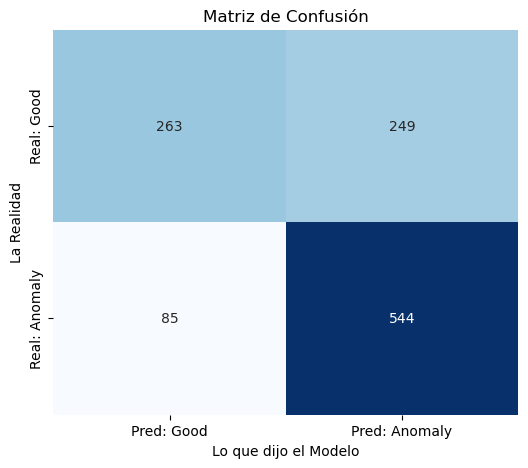

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calcular Accuracy simple
acc = accuracy_score(y_test, preds_convertidos)
print(f"--> Accuracy Global: {acc*100:.2f}%")
print("-" * 30)

# 2. Informe detallado (Precision y Recall)
print("Informe de Clasificación:")
print(classification_report(y_test, preds_convertidos, target_names=['Good (0)', 'Anomaly (1)']))
print("-" * 30)

# 3. Matriz de Confusión Visual
cm = confusion_matrix(y_test, preds_convertidos)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.xlabel('Lo que dijo el Modelo')
plt.ylabel('La Realidad')
plt.title('Matriz de Confusión')
plt.show()

Vamos a cambiar la función de carga de datos para que, en lugar de devolver la imagen aplanada, devuelva el histograma de esa imagen.

In [ ]:
import cv2
import numpy as np
from pathlib import Path
from sklearn.ensemble import IsolationForest

def cargar_histogramas_debug(root_path, filtro_camara=None, bins=32):
    X_train = []
    X_test = []
    y_test = [] 
    
    root = Path(root_path)
    print(f"1. Buscando en: {root.absolute()}")
    
    # Verificamos si la ruta existe
    if not root.exists():
        print("❌ ERROR CRÍTICO: La ruta no existe. Revisa el path.")
        return np.array([]), np.array([]), np.array([])

    contador_imagenes = 0
    
    for img_path in root.rglob('*.*'):
        # Solo procesamos imágenes
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
            
        contador_imagenes += 1
        
        # Filtro de cámara
        if filtro_camara and filtro_camara not in str(img_path):
            continue

        # LOGICA ROBUSTA PARA DETECTAR TRAIN/TEST
        # En lugar de usar índices fijos (parts[-3]), buscamos la palabra en la ruta
        path_str = str(img_path).lower() # Convertimos a minusculas para evitar errores
        
        if 'train' in path_str:
            split_type = 'train'
        elif 'test' in path_str:
            split_type = 'test'
        else:
            continue # Si no dice train ni test, lo saltamos
            
        # Detectar etiqueta good/anomaly
        is_anomaly = 0
        if 'anomaly' in path_str:
            is_anomaly = 1
        elif 'good' in path_str:
            is_anomaly = 0
            
        # Cargar y procesar
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None: 
            continue

        hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
        cv2.normalize(hist, hist)
        hist_vector = hist.flatten()
        
        if split_type == 'train':
            X_train.append(hist_vector)
        elif split_type == 'test':
            X_test.append(hist_vector)
            y_test.append(is_anomaly)

    print(f"2. Total imágenes escaneadas en carpetas: {contador_imagenes}")
    print(f"3. Imágenes guardadas en TRAIN: {len(X_train)}")
    print(f"4. Imágenes guardadas en TEST: {len(X_test)}")
    
    return np.array(X_train), np.array(X_test), np.array(y_test)

# --- EJECUCIÓN ---

# IMPORTANTE: Asegúrate de que esta ruta es correcta
ruta = "./ITD" 

# Prueba SIN filtro primero para ver si carga ALGO
X_train_hist, X_test_hist, y_test_hist = cargar_histogramas_debug(ruta, filtro_camara=None, bins=32)

# Verificación de seguridad antes de entrenar
if len(X_train_hist) > 0:
    print("\n✅ Datos cargados correctamente. Entrenando...")
    clf_hist = IsolationForest(random_state=42, contamination=0.1)
    clf_hist.fit(X_train_hist)
    print("Modelo entrenado.")
else:
    print("\n❌ STOP: No hay datos de entrenamiento. No se puede entrenar.")
    print("Consejo: Revisa que 'ruta' apunte a la carpeta donde están 'type1cam1', etc.")

1. Buscando en: c:\Users\ander\OneDrive - UPNA\4º\Extracción del conocimiento\TrabajoGrupo\ITD
2. Total imágenes escaneadas en carpetas: 5878
3. Imágenes guardadas en TRAIN: 4391
4. Imágenes guardadas en TEST: 1141

✅ Datos cargados correctamente. Entrenando...
Modelo entrenado.


--- Evaluando el modelo en el set de TEST ---

Reporte de Clasificación:
              precision    recall  f1-score   support

    Good (0)       0.62      0.88      0.73       512
 Anomaly (1)       0.86      0.56      0.68       629

    accuracy                           0.71      1141
   macro avg       0.74      0.72      0.71      1141
weighted avg       0.75      0.71      0.70      1141



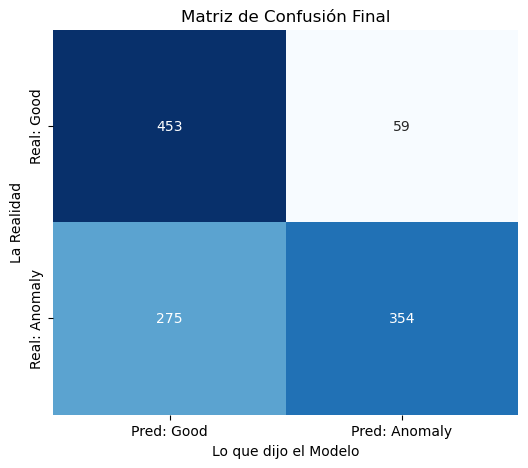


RESUMEN: De las 629 telas defectuosas, hemos detectado 354.
Porcentaje de éxito detectando fallos (Recall): 56.28%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Evaluando el modelo en el set de TEST ---")

# 1. PREDECIR
# El modelo nos da: 1 (Normal) y -1 (Anomalía)
preds_raw = clf_hist.predict(X_test_hist)

# 2. TRADUCIR
# Nosotros queremos: 0 (Normal/Good) y 1 (Anomalía)
# Si la predicción es -1, es anomalía (1). Si no, es normal (0).
preds_convertidos = [1 if x == -1 else 0 for x in preds_raw]

# 3. ANALIZAR RESULTADOS

# Matriz de confusión
cm = confusion_matrix(y_test_hist, preds_convertidos)

# Reporte completo (Precisión, Recall, F1-Score)
print("\nReporte de Clasificación:")
print(classification_report(y_test_hist, preds_convertidos, target_names=['Good (0)', 'Anomaly (1)']))

# 4. VISUALIZAR MATRIZ
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Good', 'Pred: Anomaly'],
            yticklabels=['Real: Good', 'Real: Anomaly'])
plt.xlabel('Lo que dijo el Modelo')
plt.ylabel('La Realidad')
plt.title('Matriz de Confusión Final')
plt.show()

# 5. ANÁLISIS RÁPIDO
tp = cm[1, 1] # Aciertos de anomalía
fn = cm[1, 0] # Anomalías que se nos escaparon
total_anomalies = tp + fn

if total_anomalies > 0:
    recall = (tp / total_anomalies) * 100
    print(f"\nRESUMEN: De las {total_anomalies} telas defectuosas, hemos detectado {tp}.")
    print(f"Porcentaje de éxito detectando fallos (Recall): {recall:.2f}%")
else:
    print("\nNo había anomalías en este test para evaluar.")

Ahora con HOG:

Cargando datos de TODAS las cámaras...
Extrayendo HOG desde: ./ITD...
Dimensiones Train Total (HOG): (4391, 1764)
Dimensiones Test Total (HOG): (1141, 1764)
Entrenando con HOG (Conjunto completo)...


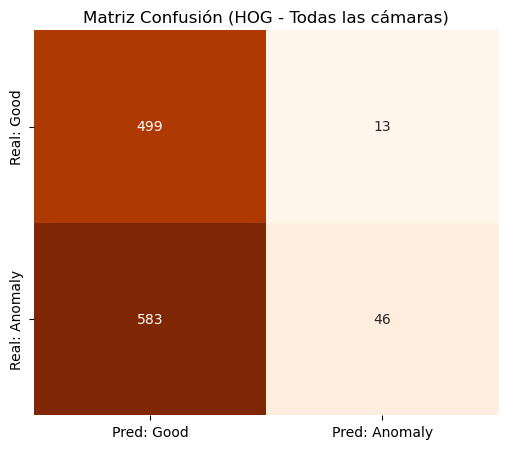

              precision    recall  f1-score   support

        Good       0.46      0.97      0.63       512
     Anomaly       0.78      0.07      0.13       629

    accuracy                           0.48      1141
   macro avg       0.62      0.52      0.38      1141
weighted avg       0.64      0.48      0.35      1141



In [ ]:
from skimage.feature import hog
from skimage import exposure
import cv2
import numpy as np
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def cargar_datos_hog(root_path, filtro_camara=None, image_size=(128, 64)):
    """
    Lee imágenes y extrae características HOG (forma y textura).
    """
    X_train = []
    X_test = []
    y_test = [] 
    
    root = Path(root_path)
    print(f"Extrayendo HOG desde: {root_path}...")
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg']:
            continue
            
        if filtro_camara and filtro_camara not in str(img_path):
            continue

        parts = img_path.parts
        try:
            split_type = parts[-3]
            label_str = parts[-2]
        except IndexError:
            continue
            
        # 1. Cargar en GRIS (HOG trabaja sobre un solo canal normalmente)
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        
        # 2. Resize (HOG necesita tamaño fijo)
        img = cv2.resize(img, image_size)
        
        # 3. Calcular HOG
        # orientations: cuántas direcciones detecta (9 es estándar)
        # pixels_per_cell: tamaño del bloque (8x8 es detalle fino, 16x16 más grueso)
        hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
        
        # hog_features ya es un vector aplanado listo para usar
        
        if split_type == 'train':
            X_train.append(hog_features)
        elif split_type == 'test':
            is_anomaly = 1 if label_str == 'anomaly' else 0
            X_test.append(hog_features)
            y_test.append(is_anomaly)

    return np.array(X_train), np.array(X_test), np.array(y_test)

# --- EJECUCIÓN CON TODAS LAS CÁMARAS ---

# 1. Cargar datos (ponemos None para que NO filtre y lea todo)
ruta = "./ITD"
print("Cargando datos de TODAS las cámaras...")
X_train_hog, X_test_hog, y_test_hog = cargar_datos_hog(ruta, filtro_camara=None, image_size=(64, 64))

print(f"Dimensiones Train Total (HOG): {X_train_hog.shape}")
print(f"Dimensiones Test Total (HOG): {X_test_hog.shape}")

# Verificación de seguridad
if len(X_train_hog) > 0:
    # 2. Entrenar Isolation Forest
    print("Entrenando con HOG (Conjunto completo)...")
    # Nota: Al mezclar muchas telas distintas, quizás necesites subir la contaminación
    clf_hog = IsolationForest(random_state=42, contamination=0.05) 
    clf_hog.fit(X_train_hog)

    # 3. Predecir
    preds = clf_hog.predict(X_test_hog)
    preds_convertidos = [1 if x == -1 else 0 for x in preds]

    # 4. Ver resultados
    cm = confusion_matrix(y_test_hog, preds_convertidos)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
                xticklabels=['Pred: Good', 'Pred: Anomaly'],
                yticklabels=['Real: Good', 'Real: Anomaly'])
    plt.title('Matriz Confusión (HOG - Todas las cámaras)')
    plt.show()

    print(classification_report(y_test_hog, preds_convertidos, target_names=['Good', 'Anomaly']))
else:
    print("❌ Error: No se han cargado datos. Revisa la ruta.")

## Leer datos todos juntos

Leemos mezclando test y train, y luego particioanremos todos los datos en train, val y test

In [14]:
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

def cargar_datos_crudos(root_path, image_size=(64, 64)):
    """
    Lee las imágenes y devuelve sus píxeles crudos.
    Sin HOG, sin filtros, sin nada raro.
    """
    X_raw = []
    y_raw = []
    
    root = Path(root_path)
    print(f"📂 Leyendo imágenes crudas desde: {root.absolute()} ...")
    
    if not root.exists():
        print("❌ Error: La ruta no existe.")
        return np.array([]), np.array([])

    contador = 0
    
    for img_path in root.rglob('*.*'):
        if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg', '.bmp']:
            continue
            
        # --- 1. ETIQUETADO ---
        # Si la ruta tiene la palabra "anomaly", es un 1. Si no, 0.
        path_str = str(img_path).lower()
        if 'anomaly' in path_str:
            label = 1
        else:
            label = 0
            
        # --- 2. LECTURA RAW ---
        # Leemos en Blanco y Negro (o RGB si prefieres, pero B/N es mejor para empezar)
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None: continue
        
        # --- 3. RESIZE OBLIGATORIO ---
        # Aunque sean datos crudos, necesitamos que todas midan lo mismo
        # para poder meterlas en una matriz.
        img = cv2.resize(img, image_size)
        
        # --- 4. APLANAR (FLATTEN) ---
        # Convertimos la matriz 64x64 en una fila de 4096 números.
        # Esto es necesario para Scikit-Learn (SVM, Random Forest, etc).
        # Si fueras a usar PyTorch directo, no haríamos esto.
        img_vector = img.flatten()
        
        # Opcional: Normalizar a 0-1 (ayuda mucho a los algoritmos)
        img_vector = img_vector / 255.0
        
        X_raw.append(img_vector)
        y_raw.append(label)
        contador += 1

    print(f"✅ Leídas {contador} imágenes.")
    return np.array(X_raw), np.array(y_raw)

# --- USO: LEER Y LUEGO DIVIDIR ---

# 1. Leemos todo junto
ruta = "./ITD"
X_total, y_total = cargar_datos_crudos(ruta, image_size=(64, 64))

# 2. Hacemos la división (Train 70%, Val 15%, Test 15%)
# Paso A: Separar Train (70%) del resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_total, y_total, test_size=0.3, random_state=42, stratify=y_total
)

# Paso B: Separar el resto en Val y Test (mitad y mitad)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\n--- RESUMEN DE DATOS CRUDOS ---")
print(f"Train shape: {X_train.shape}  (Ej: 4096 columnas = 64x64 píxeles)")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# Mostramos numero de anomalias en cada conjunto
print(f"\nTrain: {sum(y_train)} anomalías")
print(f"Val: {sum(y_val)} anomalías")
print(f"Test: {sum(y_test)} anomalías")

📂 Leyendo imágenes crudas desde: c:\Users\ander\OneDrive - UPNA\4º\Extracción del conocimiento\TrabajoGrupo\ITD ...
✅ Leídas 5878 imágenes.

--- RESUMEN DE DATOS CRUDOS ---
Train shape: (4114, 4096)  (Ej: 4096 columnas = 64x64 píxeles)
Val shape:   (882, 4096)
Test shape:  (882, 4096)

Train: 675 anomalías
Val: 145 anomalías
Test: 145 anomalías
